### Import modules

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Introduction
This practical session is intended to explore tumor growth data and interpret it using mathematical models. It is divided into three parts (only the first two parts will be covered in this session):
1. Analysis of the data by basic plots
2. Fitting and comparing tumor growth models to the data in order to understand methods of single-individual parameter estimation (nonlinear regression). Use these tools to understand **tumor growth laws**
3. Using the model(s) to **predict** future tumor growth with only a limited number of initial data points

The data provided consists of measurements of tumor volumes from tumors implanted subcutaneously in the back of mice. The cells are from a murine lung cancer cell line (Lewis Lung Carcinoma). The volumes were computed from two one dimensional measures recorded using a caliper (the length $L$ and width $w$) and using the formula $V = \frac{1}{2}L\times w^2$. Volumes are given in mm$^3$ as a function of days following injection of the cells ($10^6$ cells $\simeq$ 1 mm$^3$ injected on day 0).

Are you ready to start your exploration? 

Good luck on your adventure! :)

# 1. Data analysis

Load the data in a pandas dataframe and display it

In [4]:
url_data = "http://benzekry.perso.math.cnrs.fr/DONNEES/data_table.xlsx"
df       = pd.read_excel(url_data, index_col=0)
df

1            2   ...           9            10
5           NaN    54.886377  ...          NaN          NaN
6           NaN    59.408036  ...    18.567329    26.880016
7     50.021795    85.662278  ...    73.293694          NaN
11   309.519493   261.572775  ...   126.820889   144.151300
12   324.895878   412.265650  ...   222.661158   193.401925
13   450.842120   488.450738  ...   244.726914   281.171233
14   572.450814   618.854795  ...   333.629836   294.886207
15   664.336606   798.997212  ...   367.475268   391.884141
18  1151.693754  1218.721058  ...   805.778850   744.954870
19  1338.383299  1415.471856  ...  1030.034281   990.331786
20  1522.807849  1410.149208  ...  1272.818884  1085.314905
21  1897.073737  1524.126579  ...  1555.359077  1331.189667
22          NaN  1935.415344  ...  1671.148523  1641.333918
24          NaN          NaN  ...          NaN  1992.067465
25          NaN          NaN  ...          NaN          NaN

[15 rows x 10 columns]

Get the time vector. It is in days

In [53]:
time = df.index.values
time

array([ 5,  6,  7, 11, 12, 13, 14, 15, 18, 19, 20, 21, 22, 24, 25])

Plot the growth of the first three mice.

Text(0, 0.5, 'Volume (mm^3)')

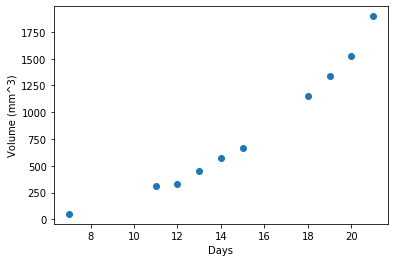

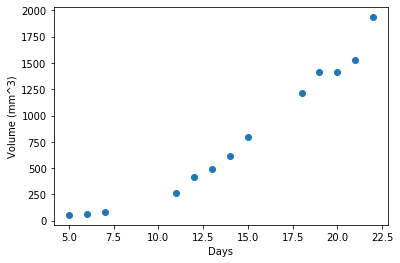

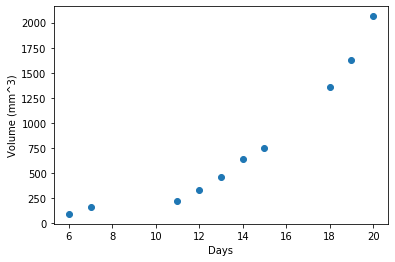

In [6]:
# Mouse 1
plt.figure(1)
plt.plot(time, df[1], 'o')
plt.xlabel('Days')
plt.ylabel('Volume (mm^3)')

# Mouse 2
plt.figure(2)
plt.plot(time, df[2], 'o')
plt.xlabel('Days')
plt.ylabel('Volume (mm^3)')

# Mouse 3
plt.figure(3)
plt.plot(time, df[3], 'o')
plt.xlabel('Days')
plt.ylabel('Volume (mm^3)')

Plot all tumor growth on the same panel

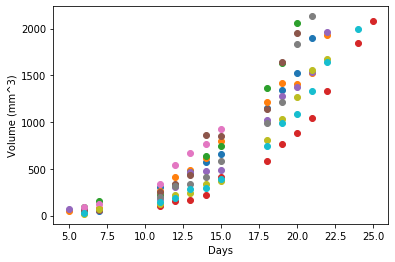

In [7]:
for mouse in df.columns:
    plt.plot(time, df[mouse], 'o')
    plt.xlabel('Days')
    plt.ylabel('Volume (mm^3)')

Plot the average of the data with error bars as standard deviations

Text(0, 0.5, 'Volume (mm^3)')

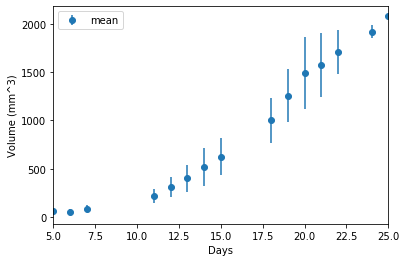

In [8]:
# Generate columns with mean
df['mean'] = df.mean(axis=1)
# Generate columns with std
df['std'] = df.std(axis=1)
df[['mean']].plot(fmt='o', yerr=df['std'])
plt.legend(loc='upper left')
plt.xlabel('Days')
plt.ylabel('Volume (mm^3)')

From the individual plots, what tumor growth pattern/equation would you suggest? How could you simply graphically test it?

Text(0, 0.5, 'Volume (mm^3)')

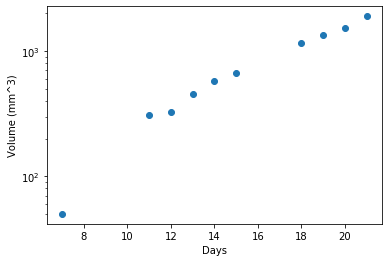

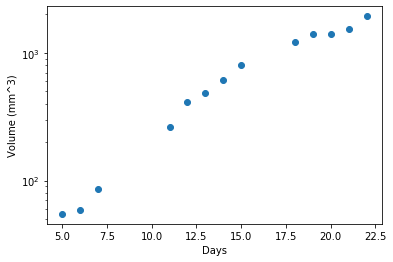

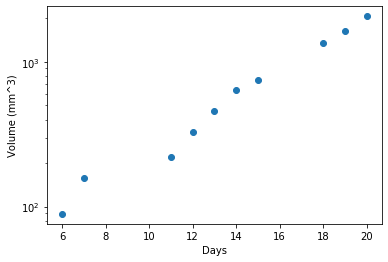

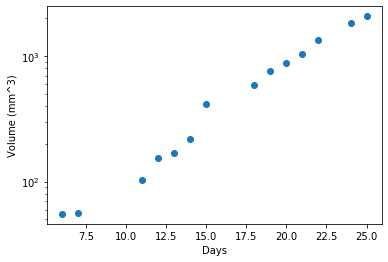

In [9]:
# Exponential growth
# Should be linear in log scale
# Mouse 1
plt.figure(1)
plt.semilogy(time, df[1], 'o')
plt.xlabel('Days')
plt.ylabel('Volume (mm^3)')

# Mouse 2
plt.figure(2)
plt.semilogy(time, df[2], 'o')
plt.xlabel('Days')
plt.ylabel('Volume (mm^3)')

# Mouse 3
plt.figure(3)
plt.semilogy(time, df[3], 'o')
plt.xlabel('Days')
plt.ylabel('Volume (mm^3)')

# Mouse 4
plt.figure(4)
plt.semilogy(time, df[4], 'o')
plt.xlabel('Days')
plt.ylabel('Volume (mm^3)')

# 2. Model fitting. Parameter estimation

**Problem:**

Considering $n$ volume observations $(V_1,\cdots,V_n)$ at time points $(t_1, \cdots, t_n)$, we would like to see whether these data could have been generated by a given function 
$$V: \begin{array}{ccc} \mathbb{R}\times \mathbb{R}^p & \longrightarrow & \mathbb{R} \\
				(t,\theta)            & \longmapsto    & V(t,\theta)\end{array}$$
depending on time $t$ and a vector of parameters $\theta\in \mathbb{R}^p$.

Another – closely related – problem is to find a set of parameters $\hat{\theta}$ that would "best" describe the data.

In our context a model will be the combination of two parts:
1. The structural model $V$ (deterministic)
2. An observation model linking the model to the observations (error model, stochastic)

The latter is defined by assuming that the observations were generated by the model plus some measurements error and we write
$$
V_j = V(t_j; \theta) + \sigma_j \varepsilon_j.
$$
where $\sigma_j\varepsilon_j$ describes the error term. It is often natural to assume that this error term is gaussian, with expectation zero. $\sigma_j$ is the standard deviation of the error and the $\varepsilon_j$ are independent and identically distributed random variables with
$$
\varepsilon_j \sim \mathcal{N}(0, 1).
$$

## Linear least-squares
We will first assume a constant error model (i.e. $\sigma_j=\sigma,\, \forall j$) and an exponential structural model:
$$
V\left(t; \left(V_0, \alpha \right)\right) = V_0 e^{\alpha t}.
$$
Transform the problem so that it reduces to a linear regression.

$$
\ln(V_j) = \ln\left(V_0\right) + \alpha t_j + \sigma \varepsilon_j
$$

Using the formula seen in class, build the least-squares matrix for fitting the first tumor volume data

In [10]:
volume = df[1].values
time   = time[~np.isnan(volume)]
volume = volume[~np.isnan(volume)]
y      = np.log(volume)
M      = np.stack((np.ones(len(time)), time), axis=1)
C      = M.transpose().dot(M)
C

array([[  10.,  150.],
       [ 150., 2430.]])

Solve the system

In [0]:
param_opt = np.linalg.solve(C, M.transpose().dot(y))

Plot the regression line together with the data

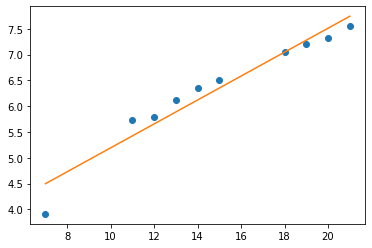

In [12]:
time_plot = np.linspace(start=time[0], stop=time[-1], num=1000)
y_plot    = param_opt[0] + param_opt[1]*time_plot
plt.plot(time, y, 'o')
plt.plot(time_plot, y_plot);

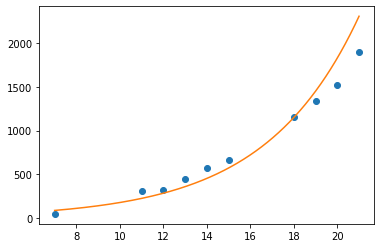

In [13]:
plt.plot(time, volume, 'o')
plt.plot(time_plot, np.exp(param_opt[0] + param_opt[1]*time_plot))

Compute the estimate of $\sigma^2$, given by
$$
s^2 = \frac{1}{n-2}\sum_{j=1}^n\left(y_j - M\hat{\theta}\right)^2
$$
with $\hat{\theta}$ the vector of optimal parameters just found.

In [0]:
residuals = y - M.dot(param_opt)
s2 = 1/(len(time)-2)*residuals.dot(residuals) # estimator of error model variance

Deduce the estimation of the covariance matrix of the parameter estimates, given by
$$
\sigma \left(M^T M\right)^{-1}
$$
Print the standard errors on the parameter estimates.

In [15]:
cov = s2*np.linalg.inv(C)
se  = np.sqrt(np.diag(cov))
se

array([0.33280459, 0.02134942])

Compute a 95\% interval for the parameters

In [0]:
from scipy.stats import t
alpha = 0.05
t_value = t.ppf((1-alpha/2), len(time) - 2)

In [17]:
int_logV0 = [param_opt[0] - se[0]*t_value, param_opt[0] + se[0]*t_value]
int_alpha = [param_opt[1] - se[1]*t_value, param_opt[1] + se[1]*t_value]
print("Confidence interval V0 = [{0:.3g}, {1:.3g}]".format(*np.exp(int_logV0)))
print("Confidence interval log(V0) = [{0:.3g}, {1:.3g}]".format(*int_logV0))
print("Confidence interval alpha = [{0:.3g}, {1:.3g}]".format(*int_alpha))

Confidence interval V0 = [8.23, 38.2]
Confidence interval log(V0) = [2.11, 3.64]
Confidence interval alpha = [0.182, 0.281]


Let's use the built-in ordinary least-squares from the statsmodels module to verify our results

In [18]:
import statsmodels.api as sm
X = sm.add_constant(time)
model = sm.OLS(y, X)
results = model.fit()
results.summary()

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     117.8
Date:                Sat, 08 Feb 2020   Prob (F-statistic):           4.59e-06
Time:                        15:20:56   Log-Likelihood:               -0.57115
No. Observations:                  10   AIC:                             5.142
Df Residuals:                       8   BIC:                             5.747
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8756      0.333      8.640      0.000       2.108       3.643
x1             0.2317      0.021     10.854      0.000       0.182       0.281
==============================================================================
Omnibus:                        3.611   Durbin-Watson:                   1.356
Prob(Omnibus):                  0.164   Jarque-Bera (JB):                1.439
Skew:                          -0.927   Prob(JB):                        0.487
Kurtosis:                       3.137   Cond. No.                         57.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Considering that the number of injected cells is $10^6$ cells, which corresponds to $V_0 = 1$ mm$^3$, and looking at the fit, what do you conclude about the validity of the exponential model?

## Nonlinear least-squares

### Competition and the logistic model
The above observations demonstrated that the tumor growth had to be faster than their actual growth rate during the observation phase, if starting from $V(t=0) = 1$ mm$^3$. This suggests to look for models that would exhibit such growth deceleration. In ecology, when modeling the growth of a population, a famous model for explaining growth deceleration and saturation is the logistic model. A tumor being a population of cells, it appears natural to test this model against our data. The logistic model states that the individuals (here the tumor cells) would compete for nutrients or space. Introducing the concept of *carrying capacity* $K$ as the maximal reachable size for the population, the fraction of cells able to divide is then $1-\frac{V}{K}$ and the model writes
$$
\left\lbrace\begin{array}{l}
\frac{dV}{dt} = \alpha V\left(1 - \frac{V}{K}\right)\\
V(t=0) = 1
\end{array}
\right.
\quad 
\Longrightarrow
\quad
V(t) = \frac{K}{1+(K-1)e^{-\alpha t}}.
$$

Define a python function ``logistic(time, alpha, K)`` for simulation of this model

In [0]:
def logistic(time, alpha, K):
    V = K/(1+(K-1)*np.exp(-alpha*time))
    return V

Import the curve_fit function from the scipy module

In [0]:
from scipy.optimize import curve_fit

Use it to fit the logistic model to the data of the first tumor growth

In [0]:
popt, cov = curve_fit(logistic, time, volume, p0=[0.5, 5000])

Plot the result

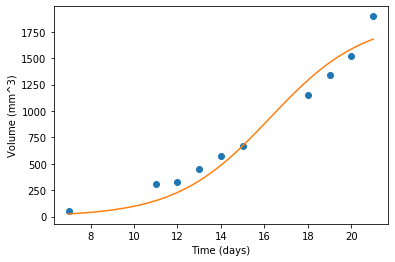

In [22]:
y_plot = logistic(time_plot, *popt)
plt.plot(time, volume, 'o');
plt.plot(time_plot, y_plot);
plt.xlabel("Time (days)");
plt.ylabel("Volume (mm^3)");

## Identifiability
The improvement of this model as compared to the previous model is notable. However, the cost for this has been to add a parameter to the model. How do we know that we are not overfitting now? In other words, isn't it too easy to fit the growth curves with three parameters. This is linked to the question of **identifiability** of the parameters. The general theory of statistical estimation offers great tools for such a purpose. Specifically, estimators are **random variables**. As such, they have a distribution coming from the fact that the data itself is uncertain. For a single parameter, the standard deviation of this distribution is called the **standard error**. An important property of the least-square estimator $\hat{\theta}$ is that it is asymptotically normally distributed and its asymptotic covariance matrix $C$ can be estimated from the combination of : 1) the (estimated) variance of the measurement error $\hat{\sigma}^2$ and 2) the jacobian matrix of the model evaluated in $\hat{\theta}$. Specifically, denoting $J$ the (weighted) jacobian matrix of the model, one can show that asymptotically
$$
\hat{\theta} \sim \mathcal{N}\left(\theta^*, \hat{\sigma}^2\left(J\cdot J^T\right)^{-1}\right)
$$
where $\theta^*$ is the true value assumed to have generated the data (which we are estimating with $\hat{\theta}$). I invite you to think two minutes about why the presence of $\hat{\sigma}$ as a proportional term and $J$ as an inversely proportional term make sense. From $C$ the standard error ($se$) and relative standard error (rse) on parameter $p$ are defined by
$$
se\left(\hat{\theta}^p\right) = \sqrt{C_{p,p}} \quad rse\left(\hat{\theta}^p\right) = \frac{se\left(\hat{\theta}^p\right)}{\hat{\theta}^p}\times 100
$$

We will now compute such standard errors.

Install the numdifftools package for jacobian computations

In [23]:
!pip install numdifftools

     |████████████████████████████████| 962kB 2.7MB/s 


Load the Jacobian function

In [0]:
from numdifftools import Jacobian

Define a ``logistic_t`` function of the parameters only

In [0]:
logistic_t = lambda param: logistic(time, *param)

Compute the jacobian at the parameters estimates

In [0]:
jac_f = Jacobian(logistic_t)
J = jac_f(popt)

Compute the covariance matrix of the estimates. Compare with the value obtained from the ``curve_fit`` function

In [27]:
residuals   = volume - logistic(time, *popt)
n           = len(time)
s2          = 1/(n-2)*residuals.transpose().dot(residuals)
cov_SB      = s2*np.linalg.inv(J.transpose().dot(J))
se_logistic = np.sqrt(np.diag(cov_SB))
cov_SB

array([[ 1.94440386e-04, -1.58528555e+00],
       [-1.58528555e+00,  2.26365833e+04]])

In [28]:
cov

array([[ 1.94438786e-04, -1.58538894e+00],
       [-1.58538894e+00,  2.26388804e+04]])

Compute relative standard errors on the parameters (i.e. standard errors divided by their value). What do you conclude about practical identifiability of the model? How about the goodness-of-fit?

In [29]:
rse = np.sqrt(np.diag(cov))/popt*100
print("Standard errors = {0:.3g}%, {1:.3g}%".format(*rse))

Standard errors = 3.01%, 8.07%


### The generalized logistic model

The previous results suggest that the logistic model is still not great at describing the entire growth curves. This motivates us to consider an even more flexible sigmoidal model: the generalized logistic model. It consists in modulating the strength of the competition through a power $\gamma$ and writes:
$$
\left\lbrace\begin{array}{l}
\frac{dV}{dt} = \alpha V\left(1 - \left(\frac{V}{K}\right)^\gamma\right)\\
V(t=0) = 1
\end{array}
\right.
\quad 
\Longrightarrow
\quad
V(t) = \frac{K}{\left(1+(K^\gamma-1)e^{-\alpha\gamma t}\right)^{\frac{1}{\gamma}}}.
$$

Write a model function ``generalized_logistic`` for simulation of this model

In [0]:
def generalized_logistic(time, alpha, K, gamma):
    V = K/(1+(K**gamma - 1)*np.exp(-alpha*gamma*time))**(1/gamma)
    return V

Fit the model and plot the result

In [31]:
popt, cov = curve_fit(generalized_logistic, time, volume, p0=[0.5, 5000, 0.1], maxfev=5000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


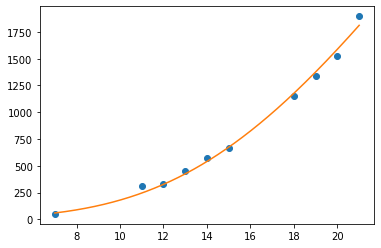

In [32]:
plt.plot(time, volume, 'o')
plt.plot(time_plot, generalized_logistic(time_plot, *popt))

Look at standard errors of the parameter estimates. What do you conclude about practical identifiability of the model?

In [33]:
rse = np.sqrt(np.diag(cov))/popt*100
print("Standard errors = {0:.3g}%, {1:.3g}% {2:.3g}%".format(*rse))

Standard errors = 7.9e+04%, 128% 7.91e+04%


## Likelihood maximization

Let's remember of the general statistical observation model

$$
V_j = V(t_j; \theta) + \sigma_j \varepsilon_j.
$$

*Error model*

An important assumption of the model is how does $\sigma_j$ depend on the volume. The first step we did before was to consider $\sigma_j$ as *constant* (i.e. independent of $j$), which meant that for all the observations, the magnitude of the error is the same. However, it appears also reasonable to consider that from our measurement technique (calipers), larger tumors result in larger errors. A natural assumption could then be a *proportional* error model described by $\sigma_j = \sigma V(t_j, \theta)$. In our case, a detailed study of 133 measurements that were performed twice on the same tumor established a slightly more refined model but we will assume a proportional error model for simplicity.

*Likelihood*

A central concept in model fitting and parameter estimation is the notion of likelihood and likelihood maximization. The likelihood of the data is defined as the probability density function of the data, under the assumption it has been generated by the model $V$ with parameters $\theta$ and $\sigma$. Note that $\sigma$ is often unknown and is a parameter to be established. However in our analysis we could compute it from the analysis mentioned above and we will take here $\sigma = 0.1$ (10% error). From the formula above, under the independence and normality assumptions we can compute it to get
$$
L(\theta) = p(V_1,\cdots,V_n;\theta)=\prod_{j=1}^n p(V_j ;\theta) = \prod_{j=1}^n \frac{1}{\sigma_j\sqrt{2 \pi}}e^{-\frac{\left(V_j - V(t_j,\theta)\right)^2}{2\sigma_j^2}}
$$
At this point, it is natural to consider the log-likelihood $l(\theta, \sigma)=\ln\left(L(\theta)\right)$ to simplify the calculations. We get
\begin{align}
l(\theta) & = - \sum_{j= 1}^{n} \frac{\left(V_j - V(t_j,\theta)\right)^2}{2\sigma_j^2} - \sum_{j=1}^n \ln(\sigma_j) - n \ln(\sqrt{2\pi}) \\
l(\theta) & = - \sum_{j= 1}^{n} \frac{\left(V_j - V(t_j,\theta)\right)^2}{2\sigma^2 V(t_j, \theta)^2} - n \ln(\sigma) - \sum_{j=1}^n \ln(V(t_j,\theta)) - n \ln(\sqrt{2\pi})
\end{align}
To simplify further, we will replace $V(t_j, \theta)$ by the observation $V_j$ in the terms above coming from the error model (third term and denominator in the first sum). The maximization of the log-likelihood then becomes equivalent to the following weighted least squares minimization problem (the $\sigma$s can be removed because they don't change the minimization problem):
$$
\hat{\theta} = \underset{\theta}{\rm argmin}\left|\left|\frac{V-V(t;\theta)}{V}\right|\right|^2.
$$
where $V = (V_1, \cdots, V_n)$, $V(t;\theta) = (V(t_1; \theta), \cdots, V(t_n; \theta))$ and $||\cdot||$ is the discrete $L^2$ norm (sum of squares).

#### The "magical" Gompertz model

Looking at the values of the parameter $\gamma$ in the generalized logistic model, we see that its value was identified to be very small. When $\gamma$ tends to zero, the expression obtained is equal to the very popular Gompertz model, which can be expressed by the following differential equation and analytical expression:
$$
\left\lbrace\begin{array}{l}
\frac{dV}{dt} = \left(\alpha_0 - \beta\ln\left(\frac{V}{V_c}\right)\right)V\\
V(t=0) = 1
\end{array}\right.
\quad 
\Rightarrow
\quad
V(t) = V_c\left(\frac{V_I}{V_c}\right)^{e^{-\beta t}}e^{\frac{\alpha_0}{\beta}\left(1-e^{-\beta t}\right)}
$$
where $V_c$ is the volume of one cell (a constant equal to $10^{-6}$), $\alpha_0$ is the proliferation rate at one cell and $\beta$ is the rate of exponential decrease of the relative growth rate. Indeed, one can show that the equation above is equivalent to 
$$
\left\lbrace\begin{array}{l}
\frac{dV}{dt} = \alpha_1 e^{-\beta t}V\\
V(t=0) = 1
\end{array}\right.
$$
with $\alpha_1=\alpha_0 +\beta \ln(V_c)$.

This model is implemented in the following function

In [0]:
def gompertz(time, alpha0, beta):
    Vc = 1e-6
    VI = 1
    V  = Vc*(VI/Vc)**(np.exp(-beta*time))*np.exp(alpha0/beta*(1-np.exp(-beta*time)))
    return V

Fit this model to the data and assess the goodness of fit and standard errors. Take $\alpha_0 = 0.1$ and $\beta = 0.01$ as initial conditions.

In [37]:
popt_gomp, cov_gomp = curve_fit(gompertz, time, volume, p0=[0.1, 0.01])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


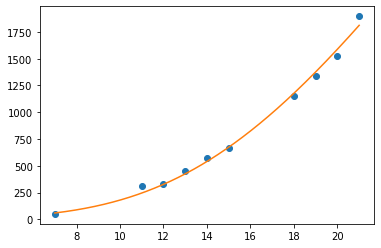

In [40]:
plt.plot(time, volume, 'o')
plt.plot(time_plot, gompertz(time_plot, *popt_gomp))

In [41]:
rse_gomp = np.sqrt(np.diag(cov_gomp))/popt_gomp*100
print("Standard errors = {0:.3g}%, {1:.3g}%".format(*rse_gomp))

Standard errors = 4.12%, 4.85%


#### The power law model as a simple and biologically interpretable model
Although widely employed due to its excellent descriptive power, one of the main criticism addressed to the Gompertz model is its lack of biological ground. Indeed, while the parameter $\alpha_0$ can be interpreted from the duration of the cell cycle, the parameter $\beta$ remains heuristic. It is not a physiological parameter that could be experimentally measured and can only be assessed through fitting the growth curve. 

The **power law** model is yet another model which consists in assuming that the proliferative tissue – instead of being a constant fraction of the tumor volume as in the exponential model – is rather proportional to the volume of the tumor elevated to a power $\gamma$. This power (or rather the triple of it) can be interpreted as the fractal (Hausdorff) dimension of the proliferative tissue. For example, when $\gamma=\frac{2}{3}$ then the proliferative tissue would only be two-dimensional within a three-dimensional tumor. This could correspond to a proliferative rim limited to the surface of the tumor, and would make sense because the vascularization of a tumor often occurs through its surface. However, an active process of tumor-driven vasculature development (the tumor **neo-angiogenesis**) induces the growth of new infiltrative blood vessels. From the naturall tree structure of the blood network, a fractal dimension naturally occurs and the proliferative tissue, being in the vicinity of the blood vessels, inherits this dimension. Summing up, this gives the following simple differential equation which can, once again, be solved analytically:
$$
\left\lbrace\begin{array}{l}
\frac{dV}{dt} = \alpha V^\gamma\\
V(t=0) = 1
\end{array}
\right.
\quad 
\Longrightarrow
\quad
V(t) = (1 + \alpha (1-\gamma) t)^{\frac{1}{1-\gamma}}.
$$

In the case of $\gamma=\frac{2}{3}$, show that growth of the tumor radius is linear in time. This patterns is experimentally and clinically observed in many situations, including the growth of gliomas.

Use the following function to fit the model (initial guess $\alpha = 0.2, \; \gamma = 0.7$) to the data and assess the identifiability of its parameters. What value do you estimate for the fractal dimension of the vasculature in this data set?

In [0]:
def power_law(time, alpha, gamma):
    VI = 1
    V  = (VI**(1-gamma)+alpha*(1-gamma)*time)**(1./(1-gamma))
    return V

In [44]:
popt_pl, cov_pl = curve_fit(power_law, time, volume, p0=[0.2, 0.7])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


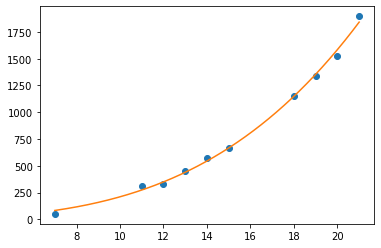

In [45]:
plt.plot(time, volume, 'o')
plt.plot(time_plot, power_law(time_plot, *popt_pl))

In [46]:
rse_pl = np.sqrt(np.diag(cov_pl))/popt_pl*100
print("Standard errors = {0:.3g}%, {1:.3g}%".format(*rse_pl))

Standard errors = 6.14%, 1.79%
